# Bonus lecture: much ado about linear regression

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2017 Winter Term 2

Mike Gelbart

In [205]:
import numpy as np
import numpy.random as npr
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

Topics:

- L2/L1 vs. mean/median connection
- Robust regression intuition
- The basis function view
- Details of Gaussian RBFs
- Regularization strength intuition
- Intercept and the mean value
- Scaling features
- Scaling regression targets
- Collinearity and conditioning
- Overfitting and $d>n$
- Classifying loss functions

5 minutes each???

## L2/L1 vs. mean/median connection

- The **mean** is the value that minimizes the **L2** error between itself and a set of numbers.
- The **median** is the value that minimizes the **L1** error between itself and a set of numbers.

In [208]:
nums = np.array([1,7,4,-3,3.4,1000,50])

print("Mean of the numbers:", np.mean(nums))
print("Median of the numbers:", np.median(nums))

Mean of the numbers: 151.771428571
Median of the numbers: 4.0


In [207]:
L2_loss = lambda x: np.sum(np.square(x-nums))
L1_loss = lambda x: np.sum(np.abs(x-nums))

print("Value the minimizes the L2 distance from the numbers:", minimize(L2_loss, 0).x[0])
print("Value the minimizes the L1 distance from the numbers:", minimize(L1_loss, 0).x[0])

Value the minimizes the L2 distance from the numbers: 23.1999986867
Value the minimizes the L1 distance from the numbers: 3.99999999385


## Robust regression intuition

(See L13.ipynb)

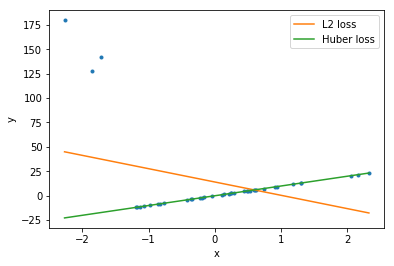

In [209]:
def gen_outlier_data(n=40,Noutliers=3):
    # generate random data
    x = np.random.randn(n)
    x = np.sort(x)
    y = 10*x
    # add random outliers
    y[:Noutliers] = -100*(x[:Noutliers]+np.random.randn(Noutliers))

    X = x[:,None] # reshape for sklearn

    return X,y

# fit a linear regression model
X,y = gen_outlier_data()
squared = LinearRegression()
squared.fit(X,y)

huber = HuberRegressor(epsilon=1)
huber.fit(X,y)

plt.plot(X,y,'.')
plt.plot(X, squared.predict(X), label="L2 loss");
plt.plot(X, huber.predict(X), label="Huber loss");
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

Question: what happens if we make one of the outliers really huge?

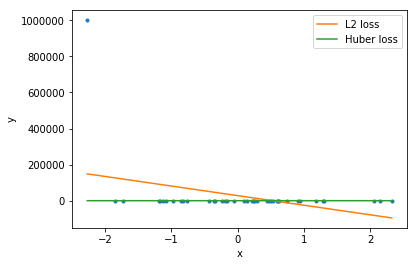

In [210]:
y[0]=1e6

squared = LinearRegression()
squared.fit(X,y)

huber = HuberRegressor(epsilon=1)
huber.fit(X,y)

plt.plot(X,y,'.')
plt.plot(X, squared.predict(X), label="L2 loss");
plt.plot(X, huber.predict(X), label="Huber loss");
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

In [211]:
np.abs(huber.predict(X)-y)

array([  1.00002271e+06,   1.46331765e+02,   1.59485578e+02,
         1.89063301e-04,   1.87473269e-04,   1.83925026e-04,
         1.80263658e-04,   1.72396952e-04,   1.63467225e-04,
         1.61272647e-04,   1.56985697e-04,   1.31269744e-04,
         1.26414921e-04,   1.25293896e-04,   1.16288637e-04,
         1.13339309e-04,   1.11023983e-04,   1.02639328e-04,
         9.12891813e-05,   8.85397930e-05,   8.25472953e-05,
         8.03266051e-05,   8.02593827e-05,   7.71588657e-05,
         6.57911808e-05,   6.27516567e-05,   6.07056222e-05,
         5.83147247e-05,   5.41979632e-05,   5.29186191e-05,
         5.15655999e-05,   4.30994203e-05,   3.01940270e-05,
         2.83373202e-05,   9.92337097e-06,   1.13393505e-06,
         5.29073503e-07,   5.65486958e-05,   6.40138556e-05,
         7.67506133e-05])

Question: why are the residuals so small? Let's imagine we shift the line up by some amount $\epsilon$. What happens?

Answer 1: because of the mean/median intuition. No matter how large you make an outlier, the median doesn't change.

Answer 2: what happens to the loss if we shift the line a bit upwards? Discussion -- the points "vote". 

## The basis function view

(See L14demo.ipynb)

- Linear regression (in our notation for transformed features) makes predictions as follows: $\hat{y} = Zv$. 
- We usually think of this row-wise: $y_1 = z_1^T v$, etc. But, what if we look at the column-wise intepretation:

$$ y = Zv= v_1 z^1 + v_2 z^2 + \ldots + v_d z^d$$ (where $z^j$ is the $j$th column of $Z$)

- Now each $z^j$ is some function of the original $x$. For example, it might be different degree polynomials. So we can write $z^j = h_j(X)$. rewrite this as

$$ y = v_1 h_1(X) + v_2 h_2(X) + \ldots + v_d h_d(X)$$

where the $h_j$ are these different functions. These are called _basis functions_. Now imagine, for illustration, that $d=1$ and $\tilde{X}$ is just a grid of points. Then we take our $h$ functions and evaluate them on the grid, giving us a curve. And then we add these curves with different weights.

The training points $X$ are used to learn these coefficients, but in the end we're learning a _function_.

## Details of Gaussian RBFs

(see L14.pdf)

$$\tilde{Z} = \begin{bmatrix} g\left(||\tilde{x}_1-x_1||\right) & g(||\tilde{x}_1-x_2||) & \ldots & g(||\tilde{x}_1-x_n||) \\ g\left(||\tilde{x}_2-x_1||\right) & g(||\tilde{x}_2-x_2||) & \ldots & g(||\tilde{x}_2-x_n||) \\ \vdots & \vdots & \vdots & \vdots \\ g\left(||\tilde{x}_t-x_1||\right) & g(||\tilde{x}_t-x_2||) & \ldots & g(||\tilde{x}_t-x_n||) \end{bmatrix}$$

where $g$ is some function like 

$$g(\varepsilon)=\exp\left(-\frac{\varepsilon^2}{2\sigma^2}\right)$$

and $t$ is the number of test examples. 

#### What does this layout mean???

It means:

- We have one feature _per training example_.
- This the columns iterate over the _training_ examples.
- As always, we have one row per "test" example, denoted $\tilde{x}_i$.
- As always, we might be building this matrix _for training_ in which case $\tilde{x}_i=x_i$.
  - Then the matrix becomes symmetric ($Z=Z^T$).
  
#### What do these entries mean???

- The entries are of the form _some quantity that falls off to zero away from the training example_.
- The $g$ function is biggest at zero, and its argument is a distance from the training example.
  - You should be thinking of them as functions of the $\tilde{x_i}$, not the $x_i$.
- In the Gaussian RBF case we fall off via the Gaussian function.
- The hyperparameter $\sigma$ controls how quickly the function drops off.

## Regularization strength intuition

(See L16demo.ipynb)

Question: what is the effect of changing the regularization strength $\lambda$?

Let's take the oversimplified case of $n=1,d=1$ with no intercept and just one point at $(x_i,y_i)=(1,1)$. We can get training error by setting $w=1$:

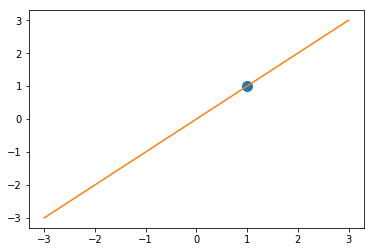

In [212]:
plt.plot(1,1,'.',markersize=20)
plt.plot((-3,3),(-3,3));

Our regularized loss is 

$$f(w)=(w-1)^2+\lambda w^2$$

- The left-hand term (data term) wants $w=1$
- The right-hand term (regularization term) wants $w=0$

In this particular case, because I picked such a simple example, we can do the math by hand. Taking the derivative and setting it to zero yields $\frac{df}{dw}=2(w-1)+2\lambda w=0$, so $w=\frac{1}{1+\lambda}$.

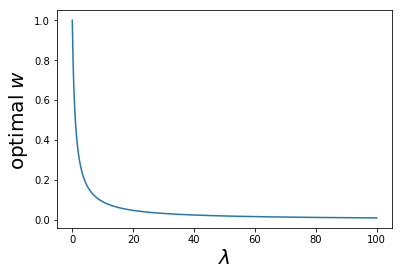

In [213]:
x = np.linspace(0,100,1000)
plt.plot(x, 1/(1+x))
plt.xlabel('$\lambda$', fontsize=20)
plt.ylabel('optimal $w$', fontsize=20);

This is a _regularization path_ but in the very simple case of just one $w$. We recover the limiting cases:

- $\lambda=0$ gives us $w=1$
- $\lambda \rightarrow \infty$ gives us $w=0$

All this pretty much generalizes to larger $n$ and $d$. So $\lambda$ controls the relative importance of training error vs. regularization.

Another question is what happens to regularization as $n$ gets large.

- As $n$ gets large, the loss term starts to dominate the regularization term for fixed $\lambda$
  - This appeals to our intuition, since we don't expect to overfit if we have lots of training data
  - There's also a Bayesian interpretation of this that's quite nice
- In practice, if we're choosing $\lambda$ with (cross)-validation anyway, we'll just get the value that works best.

## Intercept and the mean value

One question is why we bother fitting an intercept: can't we just center the target values?

The answer is that the intercept isn't always going to be equal to the mean of the target values! For example:

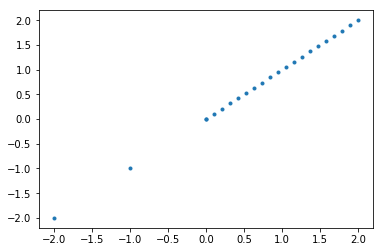

In [214]:
x = np.append(np.linspace(-2,0,3), np.linspace(0,2,20))
y = x
plt.plot(x,y,'.');

The intercept here should clearly be zero. Indeed:

In [217]:
lr = LinearRegression()
lr.fit(x[:,None],y)
lr.intercept_

0.0

And yet the mean is nonzero:

In [218]:
np.mean(y)

0.73913043478260865

## Scaling features

We've seen cases where scaling the features is important to get good performance. We can test this out:

In [219]:
n = 100
d = 10
X = np.random.randn(n,d) 
X[:,0] = X[:,0]*1000 # make the first feature on a huge scale
y = np.sum(X,axis=1) + np.random.randn(n)
Xtest = np.random.randn(1,d)

lr = LinearRegression(normalize=False)
lr.fit(X,y)

lr_scale = LinearRegression(normalize=True)
lr_scale.fit(X,y)

np.allclose(lr.predict(Xtest), lr_scale.predict(Xtest))

True

In [220]:
ridge = Ridge(normalize=False)
ridge.fit(X,y)

ridge_scale = Ridge(normalize=True)
ridge_scale.fit(X,y)

np.allclose(ridge.predict(Xtest), ridge_scale.predict(Xtest))

False

In [221]:
lasso = Lasso(normalize=False)
lasso.fit(X,y)

lasso_scale = Lasso(normalize=True)
lasso_scale.fit(X,y)

np.allclose(lasso.predict(Xtest), lasso_scale.predict(Xtest))

False

Intuition: consider the simple case of $n=2,d=2$ with no intercept for simplicity. The data set consists of two points:

$$X=\begin{bmatrix} 1 & 0 \\ 0 & 1000 \end{bmatrix} \quad y=\begin{bmatrix} 1 \\ 1 \end{bmatrix}$$

The optimal weights are $$w=\begin{bmatrix} 1 \\ 0.001 \end{bmatrix}$$

In [222]:
X = np.array([[1, 0],[0, 1000]])
y = np.array([1,1])
lr = LinearRegression(fit_intercept=False)
lr.fit(X,y)
lr.coef_

array([ 1.   ,  0.001])

In [223]:
ridge = Ridge(fit_intercept=False)
ridge.fit(X,y)
ridge.coef_

array([ 0.5  ,  0.001])

The big coefficient got pushed down, but the small one pretty much got left alone. Therefore the _ratio of the coefficients_ changed. If we scaled the second feature by 1/1000 then we'd get coefficients the same, which means they'd actually have a ratio of 1:1000. But here the ratio changed.

In [224]:
lasso = Lasso(fit_intercept=False,alpha=0.1) # if alpha=1 then we snap one of the weights to zero
lasso.fit(X,y)
lasso.coef_

array([ 0.8      ,  0.0009998])

The same sort of thing happens here.

Conclusion:

- Un-regularized linear regression: not affected by scaling
- L1 or L2-regularized linear regression: both affected by scaling (and it's usually a good idea)

## Scaling regression targets

This one is a little more insidious than the feature scaling. It seems like it would never matter. But...

In [225]:
n = 100
d = 10
X = np.random.randn(n,d) 
y = np.sum(X,axis=1) + np.random.randn(n)
Xtest = np.random.randn(1,d)

lr = LinearRegression()
lr.fit(X,y)

lr_scale = LinearRegression()
scale_factor = 10
lr_scale.fit(X,y*scale_factor)

np.allclose(lr.predict(Xtest), lr_scale.predict(Xtest)/scale_factor)

True

In [226]:
ridge = Ridge()
ridge.fit(X,y)

scale_factor = 10
ridge_scale = Ridge()
ridge_scale.fit(X,y*scale_factor)

np.allclose(ridge.predict(Xtest), ridge_scale.predict(Xtest)/scale_factor)

True

In [227]:
lasso = Lasso()
lasso.fit(X,y)

scale_factor = 10
lasso_scale = Lasso()
lasso_scale.fit(X,y*scale_factor)

np.allclose(lasso.predict(Xtest), lasso_scale.predict(Xtest)/scale_factor)

False

What's going on here?! With feature scaling it mattered for Ridge and Lasso, but here only Lasso is affected. Why?

- If I scale the values of $y$ then I can account for this by scaling all the weights by the same amount
  - (it's cleaner to think about this without an intercept)
- So, for no regularization this is fine, predictions are also scaled
- For Ridge, if you scale the weights, _both terms in the loss_ are scaled by this factor squared
  - $f(w)=||Xw-y||^2_2 + \lambda ||w||_2^2$.
  - $f(cw)=c^2||Xw-y||^2_2 + c^2 \lambda ||w||_2^2 = c^2 f(w)$.
  - Thus it's just an overall scaling of the loss, which has no affect
- For Lasso, if you scale the weights, the first term is affected more than the second
  - $f(w)=||Xw-y||^2_2 + \lambda ||w||_1$.
  - $f(cw)=c^2||Xw-y||^2_2 + \lambda c ||w||_1$.
  - This, in essence, we've scaled $\lambda$ by $1/c$. Let's test this:
  

In [228]:
lasso = Lasso() # default is alpha=1
lasso.fit(X,y)

scale_factor = 10
lasso_scale = Lasso(alpha=1*scale_factor)
lasso_scale.fit(X,y*scale_factor)

np.allclose(lasso.predict(Xtest), lasso_scale.predict(Xtest)/scale_factor)

True

The universe makes sense -- nice!

If we were picking $\lambda$ (a.k.a. `alpha`) with cross-validation then this should not end up mattering, so long as we did any scaling _before_ we picked $\lambda$.

(Thanks to Gurinder for asking about this in class!)

## Collinearity and conditioning

- We talked about collinearity. This is not just when you have two columns that are copies of each other! 



In [229]:
n = 1000
d = 100
X = np.random.randn(n,d) 
y = np.sum(X,axis=1) + np.random.randn(n)

X[:,0] = X[:,1]

print(np.linalg.cond(X.T@X))

np.linalg.inv(X.T@X)

2.50412751027e+15


LinAlgError: Singular matrix

In [230]:
X[:,0] = np.sum(X[:,1:],axis=1)

print(np.linalg.cond(X.T@X))

np.linalg.inv(X.T@X)

7.74797803267e+18


array([[  5.71241410e+10,  -5.71241410e+10,  -5.71241410e+10, ...,
         -5.71241410e+10,  -5.71241410e+10,  -5.71241410e+10],
       [ -5.71241410e+10,   5.71241410e+10,   5.71241410e+10, ...,
          5.71241410e+10,   5.71241410e+10,   5.71241410e+10],
       [ -5.71241410e+10,   5.71241410e+10,   5.71241410e+10, ...,
          5.71241410e+10,   5.71241410e+10,   5.71241410e+10],
       ..., 
       [ -5.71241410e+10,   5.71241410e+10,   5.71241410e+10, ...,
          5.71241410e+10,   5.71241410e+10,   5.71241410e+10],
       [ -5.71241410e+10,   5.71241410e+10,   5.71241410e+10, ...,
          5.71241410e+10,   5.71241410e+10,   5.71241410e+10],
       [ -5.71241410e+10,   5.71241410e+10,   5.71241410e+10, ...,
          5.71241410e+10,   5.71241410e+10,   5.71241410e+10]])

This one shouldn't be invertible either, but seems to be numerically invertible.

The dummy variable trap: converting a categorical variable to 

In [231]:
import pandas as pd
import seaborn as sns

titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [232]:
pd.get_dummies(titanic).head()

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,sex_female,sex_male,...,deck_C,deck_D,deck_E,deck_F,deck_G,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alive_no,alive_yes
0,0,3,22.0,1,0,7.2500,True,False,0,1,...,0,0,0,0,0,0,0,1,1,0
1,1,1,38.0,1,0,71.2833,False,False,1,0,...,1,0,0,0,0,1,0,0,0,1
2,1,3,26.0,0,0,7.9250,False,True,1,0,...,0,0,0,0,0,0,0,1,0,1
3,1,1,35.0,1,0,53.1000,False,False,1,0,...,1,0,0,0,0,0,0,1,0,1
4,0,3,35.0,0,0,8.0500,True,True,0,1,...,0,0,0,0,0,0,0,1,1,0


In [235]:
X = pd.get_dummies(titanic).dropna().as_matrix().astype('float')

np.linalg.cond(X.T@X)

1.869849571585033e+22

What does a high condition number mean for us, practically speaking? 

It means small changes in the data can lead to big changes in the weights, which is worrying.

In [236]:
X, y = X[:, 1:], X[:,0] # try to predict the first column
lr = LinearRegression()
lr.fit(X, y)
old_coef = lr.coef_

In [237]:
X[0,-1] += 1e-8 # tiny perturbation
lr.fit(X, y)
new_coef = lr.coef_
np.abs(new_coef[-1] - old_coef[-1])

0.49999948734365185

This is very worrying: we changed the feature value by $10^{-8}$ in one of the examples, and the coefficient changed by 0.5. 

Pandas' `get_dummies` has an argument `drop_first` which helps avoid this problem.

In [238]:
df = pd.get_dummies(titanic[['sex']]).dropna()
df.head()

,sex_female,sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [239]:
X = df.as_matrix().astype('float')
np.linalg.cond(X.T@X)
# np.linalg.inv(X.T@X)

1.8375796178343942

It seems OK, but that's misleading!! In practice we always fit an intercept, which can be thought of (and implemeted as) a column of ones appended to $X$.

In [240]:
Xint = np.append(X, np.ones((X.shape[0],1)),axis=1)
Xint

array([[ 0.,  1.,  1.],
       [ 1.,  0.,  1.],
       [ 1.,  0.,  1.],
       ..., 
       [ 1.,  0.,  1.],
       [ 0.,  1.,  1.],
       [ 0.,  1.,  1.]])

Now the 3rd column is the sum of the first two, which is collinearity. Indeed: 

In [241]:
np.linalg.cond(Xint.T@Xint)
# np.linalg.inv(Xint.T@Xint)

78822279090672368.0

Solving this with `drop_first`:

In [242]:
df = pd.get_dummies(titanic[['sex']], drop_first=True).dropna()
df.head()

,sex_male
0,1
1,0
2,0
3,0
4,1


In [243]:
X = df.as_matrix().astype('float')
Xint = np.append(X, np.ones((X.shape[0],1)),axis=1)

np.linalg.cond(Xint.T@Xint)
# np.linalg.inv(Xint.T@Xint)

9.7923924890242251

Next, we explore the affects of L2-regularization on dealing with this issue:

In [244]:
X = pd.get_dummies(titanic).dropna().as_matrix().astype('float')

np.linalg.cond(X.T@X)

1.869849571585033e+22

In [245]:
λ=1000
np.linalg.cond(X.T@X + λ*np.eye(X.shape[1]))

3124.7154404738185

Finally, we explore the effects of regularization on a synthetic data set with collinear features.

In [246]:
n = 1000
d = 100
X = np.random.randn(n,d) 
y = np.sum(X[:,:5],axis=1) + np.random.randn(n)
 
# make the first 3 columns identical
X[:,1] = X[:,0]
X[:,2] = X[:,0]

lr = LinearRegression()
lr.fit(X,y)
lr.coef_[:3]

array([  2.37390514e+09,  -3.15738562e+12,   3.15501172e+12])

Without regularization, the coefficients go crazy.

In [247]:
ridge = Ridge()
ridge.fit(X,y)
ridge.coef_[:3]

array([ 0.33566811,  0.33566811,  0.33566811])

With L2-regularization, they are all equal (and about $\frac13$, which makes sense since the true total weight is 1).

In [248]:
lasso = Lasso()
lasso.fit(X,y)
lasso.coef_[:3]

array([ 0.07159873,  0.        ,  0.        ])

With L1-regularization, they are not going to be crazy, but they won't all be equal. 

The solution isn't unique: I could shuffle those 3 coefficients and I'd get another solution.

In [249]:
old_score = lasso.score(X,y)
old_score

0.055650436270563652

In [250]:
lasso.fit(X,y)
lasso.coef_[:3] = lasso.coef_[2::-1] 
lasso.coef_[:3]

array([ 0.        ,  0.        ,  0.07159873])

In [251]:
new_score = lasso.score(X,y)
print(new_score)
new_score == old_score

0.0556504362706


True

## Overfitting and $d>n$

One question is what it means to overfit with a linear model: the model is so _simple_!. 

One answer is that if we have a lot of features, then we have a lot of parameters (one per feature), which can make the model complex even if it's linear. For example, with $d=n$ (or $n-1$, if we're being careful about the intercept) and the features not collinear ($X$ is a square matrix of rank $n$), we can now achieve a training error of 0 on any data set. 

Intuition: for 0 loss we need $Xw=y$. So we have $n$ equations. But we also have $n$ unknowns since we have $d$ parameters and $d=n$. So we have an $n\times n$ linear system, which should be solvable. Meaning we can get zero training error. Which sounds like overfitting.

All this relates to the conditioning and invertibility issues discussed above. Because if $d=n$ then $X^TX$ then $X^TX$ has rank $n=d$, and so its invertible and we get a unique solution (the one with zero training error). And if $d>n$ then $X^TX$ can have rank at most $n$, but it's a $d\times d$ matrix, and so it must not be invertible. In other words, the solution is not unique. There is a whole space of solutions that give zero training error.

To summarize, all these things are related: the condition number of $X^TX$, the number of features (but also their collinearity), the rank of $X^TX$, the uniqueness of the solution, the sensitivity of $w$ to changes in the data.

We can see the affects of overfitting by adding random features.

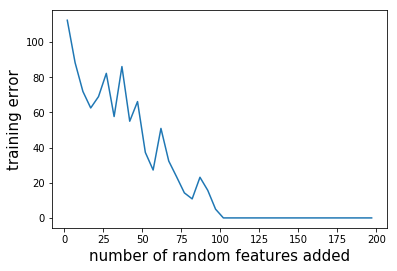

In [252]:
n = 100

training_errors = []
d_values = list(range(2,200,5))

for d in d_values:
    X = np.random.randn(n,d-1) 
    y = X[:,0] + np.random.randn(n) # y is just the first feature

    lr = LinearRegression()
    lr.fit(X,y)
    training_error = np.sum((lr.predict(X)-y)**2)
    training_errors.append(training_error)
    
plt.plot(d_values, training_errors);
plt.xlabel('number of random features added', fontsize=15)
plt.ylabel('training error', fontsize=15);

Note that we get to 0 training error when $d=n=100$ ($\pm 1$), as expected.

## Classifying loss functions

![](loss_venn2.jpg)